# **USE CASE 5.** Clustering using k-means in HFL with TFF

## Required libraries and configuration

Import required libraries

In [1]:
import os
import argparse

from pipeline.backend.pipeline import PipeLine
from pipeline.component import DataTransform
from pipeline.component import HeteroKmeans
from pipeline.component import Intersection
from pipeline.component import Evaluation
from pipeline.component import Reader
from pipeline.interface import Data

from pipeline.utils.tools import load_job_config

Define some parameters for the simulation, such the host, the guest and the arbiter in the federated scenario then using the FATE framework.

FATE provides some datasets ready to use with theire framework. To use them, we just cloned the datased in our local machine.

In [2]:
guest = 9999
host = 10000
arbiter = 10000
data_base = "/home/maniaqq/Documents/TutorialFATE/FATE/" # Path to the FATE repositoty in the local machine.
partition = 16
namespace = ""

## Loading and preparing the input data

First, we have to upload the data to the FATE framework, even when using a local machine. 

In [3]:
guest_train_data = {"name": "default_credit_hetero_guest", "namespace": f"experiment{namespace}"}
host_train_data = {"name": "default_credit_hetero_host", "namespace": f"experiment{namespace}"}

FATE uses a pipeline with components that are connected between them once added. We first have to upload the data that we want to use, and we do it as follows:

In [4]:
# initialize pipeline
pipeline = PipeLine()
# set job initiator
pipeline.set_initiator(role='guest', party_id=guest)
# set participants information
pipeline.set_roles(guest=guest, host=host, arbiter=arbiter)

# Upload the data before reading it.
pipeline.add_upload_data(file=os.path.join(data_base, "examples/data/default_credit_hetero_guest.csv"),
                            table_name=guest_train_data["name"],             # table name
                            namespace=guest_train_data["namespace"],         # namespace
                            head=1, partition=partition,                     # data info
                            extend_sid=True,                                 # extend sid 
                            auto_increasing_sid=False)

pipeline.add_upload_data(file=os.path.join(data_base, "examples/data/default_credit_hetero_host.csv"),
                            table_name=host_train_data["name"],
                            namespace=host_train_data["namespace"],
                            head=1, partition=partition,
                            extend_sid=True,
                            auto_increasing_sid=False)
pipeline.upload(drop=1)

 UPLOADING:||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||100.00%


2023-02-06 11:42:46.595 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:83 - Job id is 202302061142460446060

2023-02-06 11:42:46.605 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:98 - Job is still waiting, time elapse: 0:00:00
2023-02-06 11:42:47.612 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:98 - Job is still waiting, time elapse: 0:00:01
m2023-02-06 11:42:48.624 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:125 - 
2023-02-06 11:42:48.625 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:127 - Running component upload_0, time elapse: 0:00:02
2023-02-06 11:42:49.637 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:127 - Running component upload_0, time elapse: 0:00:03
2023-02-06 11:42:50.654 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:127 - Running component upload_0, time elapse: 0:00:04
2023-02-06 11:42:51.666 | INFO     | pipel

 UPLOADING:||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||100.00%


2023-02-06 11:42:53.152 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:83 - Job id is 202302061142526790380

2023-02-06 11:42:53.159 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:98 - Job is still waiting, time elapse: 0:00:00
2023-02-06 11:42:54.166 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:98 - Job is still waiting, time elapse: 0:00:01
m2023-02-06 11:42:55.178 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:125 - 
2023-02-06 11:42:55.179 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:127 - Running component upload_0, time elapse: 0:00:02
2023-02-06 11:42:56.191 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:127 - Running component upload_0, time elapse: 0:00:03
2023-02-06 11:42:57.204 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:127 - Running component upload_0, time elapse: 0:00:04
2023-02-06 11:42:58.215 | INFO     | pipel

## Create a Pipeline with its components, including the model

In FATE we have to create a Pipeline and then add the components that we want to use to train/predict with a model.

First we declare each component that will be used in the pipeline.
- Reader: A component to read the data from the guest and the host.
- DataTransform: A component to apply preprocessing to the data before feeding it into the model.
- Intersection: A component that applies and intersection of the data between the participants in the VFL scenario, so only data that share the ID will be used.
- Model, HeteroKmeans: This is the Kmeans model for VFL.
- Evaluation. The evaluation strategy to use. In this case, as we are doing clustering, we select clustering.

In [5]:
# define Reader components to read in data
reader_0 = Reader(name="reader_0")
# configure Reader for guest
reader_0.get_party_instance(role='guest', party_id=guest).component_param(table=guest_train_data)
# configure Reader for host
reader_0.get_party_instance(role='host', party_id=host).component_param(table=host_train_data)
#  set with match id
data_transform_0 = DataTransform(name="data_transform_0", with_match_id=True)
# set guest parameter
#data_transform_0.get_party_instance(role='guest', party_id=guest).component_param(
#    with_label=True, output_format="dense")
#data_transform_0.get_party_instance(role='host', party_id=[host]).component_param(
#    with_label=False)
data_transform_0_guest_party_instance = data_transform_0.get_party_instance(role='guest', party_id=guest)
# configure DataTransform for guest
data_transform_0_guest_party_instance.component_param(with_label=True, output_format="dense")
# get and configure DataTransform party instance of host
data_transform_0.get_party_instance(role='host', party_id=host).component_param(with_label=False)

# define Intersection components
intersection_0 = Intersection(name="intersection_0")

param = {
    "k": 2,
    "max_iter": 10
}

hetero_kmeans_0 = HeteroKmeans(name='hetero_kmeans_0', **param)
evaluation_0 = Evaluation(name='evaluation_0', eval_type='clustering')

After defining all the components, we add them all to the pipeline in order os task execution

In [6]:
# add components to pipeline, in order of task execution
pipeline.add_component(reader_0)
pipeline.add_component(data_transform_0, data=Data(data=reader_0.output.data))
# set data input sources of intersection components
pipeline.add_component(intersection_0, data=Data(data=data_transform_0.output.data))
# set train & validate data of hetero_lr_0 component
pipeline.add_component(hetero_kmeans_0, data=Data(train_data=intersection_0.output.data))
pipeline.add_component(evaluation_0, data=Data(data=hetero_kmeans_0.output.data.data[0]))

## Training in the federated scenario

Once we have the pipeline with all the components ready, we just compile the pipeline and use the fit method.

In [7]:
# compile pipeline once finished adding modules, this step will form conf and dsl files for running job
pipeline.compile()

In [8]:
# fit model
pipeline.fit()

2023-02-06 11:42:59.674 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:83 - Job id is 202302061142592735020

2023-02-06 11:42:59.682 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:98 - Job is still waiting, time elapse: 0:00:00
2023-02-06 11:43:00.690 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:98 - Job is still waiting, time elapse: 0:00:01
m2023-02-06 11:43:01.702 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:125 - 
2023-02-06 11:43:01.703 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:127 - Running component reader_0, time elapse: 0:00:02
2023-02-06 11:43:02.714 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:127 - Running component reader_0, time elapse: 0:00:03
2023-02-06 11:43:03.727 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:127 - Running component reader_0, time elapse: 0:00:04
2023-02-06 11:43:04.739 | INFO     | pipel

We can check the results of the model in different ways. The first one is using the component with the evaluation strategy defined in the pipeline

In [9]:
# query component summary
print(f"Evaluation summary: {pipeline.get_component('evaluation_0').get_summary()}")

Evaluation summary: {'hetero_kmeans_0': {'train': {'adjusted_rand_score': -0.0044485061295263814, 'fowlkes_mallows_score': 0.6951160543150361, 'jaccard_similarity_score': 0.16334428453001432}}}


The other method to check the results obtained by the model, is to log into the FATE interface and check the evaluation component. Using the interface, we can also check the tree structure at the gust and at the host.

## Evaluation with test data

In order to evaluate the model with new data, we have to create a new pipeline. In this example we will use the training data as test data, just to show how to define a pipeline for testing the model.

We have to upload the test data to the platform, but as we are using the training data, we just select it.

In [10]:
guest_eval_data = {"name": "default_credit_hetero_guest", "namespace": f"experiment"}
host_eval_data = {"name": "default_credit_hetero_host", "namespace": f"experiment"}

We need to deploy the main components from our main pipeline, those are:
- DataTransform: Needed to apply the same preprocessing to the incoming data
- Intersection: Needed to apply the intersection by ID to the data.
- HeteroKmeans: The model.

In [11]:
# Deploy required components
pipeline.deploy_component([data_transform_0, intersection_0, hetero_kmeans_0])

In [12]:
#Initiate predict pipeline
predict_pipeline = PipeLine()

# Create the reader component
reader_1 = Reader(name='reader1')
reader_1.get_party_instance(role='guest', party_id=9999).component_param(table=guest_eval_data)
reader_1.get_party_instance(role='host', party_id=10000).component_param(table=host_eval_data)

# Add data reader onto predict pipeline
predict_pipeline.add_component(reader_1)

predict_pipeline.add_component(pipeline,
                              data=Data(predict_input={pipeline.data_transform_0.input.data: reader_1.output.data}))

Now we can use the pipeline to predict

In [13]:
# Run predict model
predict_pipeline.predict()

2023-02-06 11:45:32.115 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:83 - Job id is 202302061145317926520

2023-02-06 11:45:32.122 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:98 - Job is still waiting, time elapse: 0:00:00
2023-02-06 11:45:33.129 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:98 - Job is still waiting, time elapse: 0:00:01
m2023-02-06 11:45:34.147 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:125 - 
2023-02-06 11:45:34.149 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:127 - Running component reader1, time elapse: 0:00:02
2023-02-06 11:45:35.161 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:127 - Running component reader1, time elapse: 0:00:03
2023-02-06 11:45:36.176 | INFO     | pipeline.utils.invoker.job_submitter:monitor_job_status:127 - Running component reader1, time elapse: 0:00:04
2023-02-06 11:45:37.191 | INFO     | pipeline

To check the results we may log in the platform and check the results.

## FATE platform

Using the platform provided by the FATE framework, we can check the some extra details. For example, in the below image, we can see the clusters and the instances in each one.

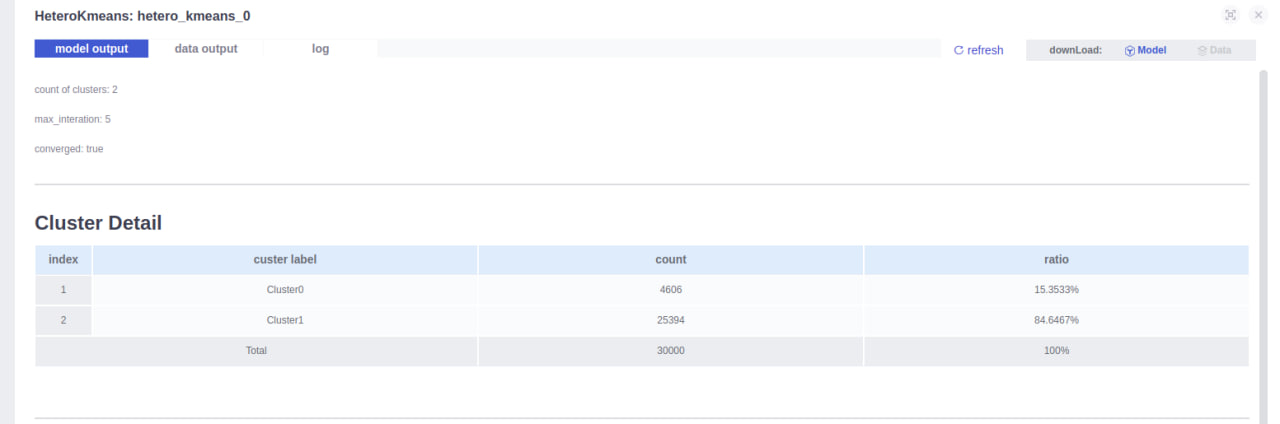

We can also check the evaluation component.

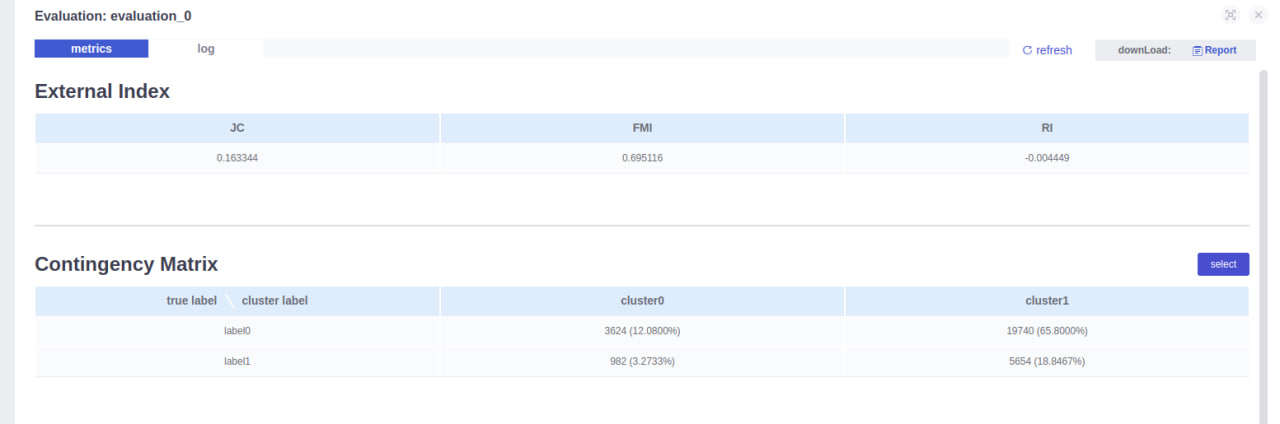